In this notebook, we will demonstrate how `TableAutomization.py` can be used for different distributions, in this case the `banana` distribution provided by the cuqipy package.
Please note that a previous read on the `table-donut.ipynb` is suggested, as that notebook provides more detailed explanations on `TableAutomization.py`; moreover, there are comparisons between the two notebooks.

### Importing the needed libraries 

In [1]:
from cuqi.distribution import DistributionGallery, Gaussian, JointDistribution
from cuqi.testproblem import Poisson1D
from cuqi.problem import BayesianProblem
import cuqi
import inspect
import numpy as np
import matplotlib.pyplot as plt
from cuqi.sampler import MH, CWMH, ULA, MALA, NUTS
import time

import scipy.stats as sps
from scipy.stats import gaussian_kde
import pandas as pd
import cProfile, pstats, io
from pstats import SortKey
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import sys
# Change the current working directory to the root of the project
sys.path.append(os.path.abspath('..'))

# Now you should be able to import the module
from utilities import TableAutomization as TA



# The banana distribution


In [2]:
# The banana distribution 
target_banana = DistributionGallery("banana")


### Plotting the "banana"

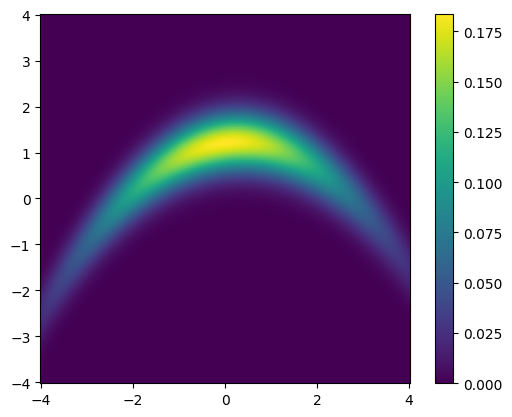

In [3]:
TA.plot_pdf_2D(target_banana, -4, 4, -4, 4)

## 1. First Example 


- Compute sampling methods with the followig parameters

1. __MH_fixed__ : scale = 0.05, Ns = 10000, Nb = 0
2. __MH_adapted__:  scale = 0.05, Ns = 8500, Nb = 1500
3.  __ULA__: scale = 0.065, Ns = 10000, Nb = 0
4.  __MALA__: scale = 0.065, Ns = 10000, Nb = 5000
5. __NUTS__: scale = 0.05, Ns = 1000, Nb = 100


In [12]:
df , (fig, axs) = TA.create_comparison(target_banana, 0.05, 100, 5, x0 = np.array([1, 1]), seed = 12, chains=2, selected_criteria=["ESS"])

Sample 105 / 105

Average acceptance rate: 0.98 

Sample 105 / 105

Average acceptance rate: 0.74 MCMC scale: 0.8701212338747437 



ValueError: Proposal should be either None, cuqi.distribution.Distribution conditioned only on 'location' and 'scale', lambda function, or cuqi.distribution.Normal conditioned only on 'mean' and 'std'

- Print table

In [ ]:
TA.print_table(df)

+----------+---------+----------+-------+---------+---------+------+--------+----------+
|  Method  | Samples | Burn-ins | Scale | ESS(v0) | ESS(v1) |  AR  | LogPDF | Gradient |
+----------+---------+----------+-------+---------+---------+------+--------+----------+
| MH_fixed |   100   |    5     |  0.05 |  1.961  |  2.038  | 0.98 |  105   |    0     |
|   NUTS   |   100   |    5     |   -   |  10.261 |  2.004  | 0.54 |  349   |   349    |
+----------+---------+----------+-------+---------+---------+------+--------+----------+


In [8]:
CWMH_sampler = CWMH(target_banana, scale = 0.05, x0=np.ones(target_banana.dim))
CWMH_samples = CWMH_sampler.sample(100,10)
CWMH_samples.acc_rate

Sample 110 / 110

Average acceptance rate all components: 0.98 



array([1.  , 0.96])

In [10]:
CWMH_sampler = NUTS(target_banana, scale = 0.05, x0=np.ones(target_banana.dim))
CWMH_samples = CWMH_sampler.sample(100,10)
CWMH_samples.acc_rate

TypeError: Sampler.__init__() got an unexpected keyword argument 'scale'

Observations:
- the conclusions are quite similar to the donut distributin: 
    - The MH_fixed is a bad sampling method in this: the sample are correlated 
    - the MH_adapted is still not great, however, one can see the improvement in the ESS value, also AR is lower, which might be due to adapting the scale to a higher one. 
    - Neither of these use gradient, thus the number of computed Gradients is 0
    - the ULA method shows a good ESS; an accceptence rate of 1.0, this is expected since ULA does not have the choice of declining a step
    - MALA improves upon ULA with a more balanced ESS but at the cost of increased computational complexity. 
    - NUTS: significantly outperforms other methods
- compared to donuts distribution, we can see that the NUTS sampling method has smaller comutational cost

- Now we will take a look at the samples of each method plotted onto the "banana" distribution graphs

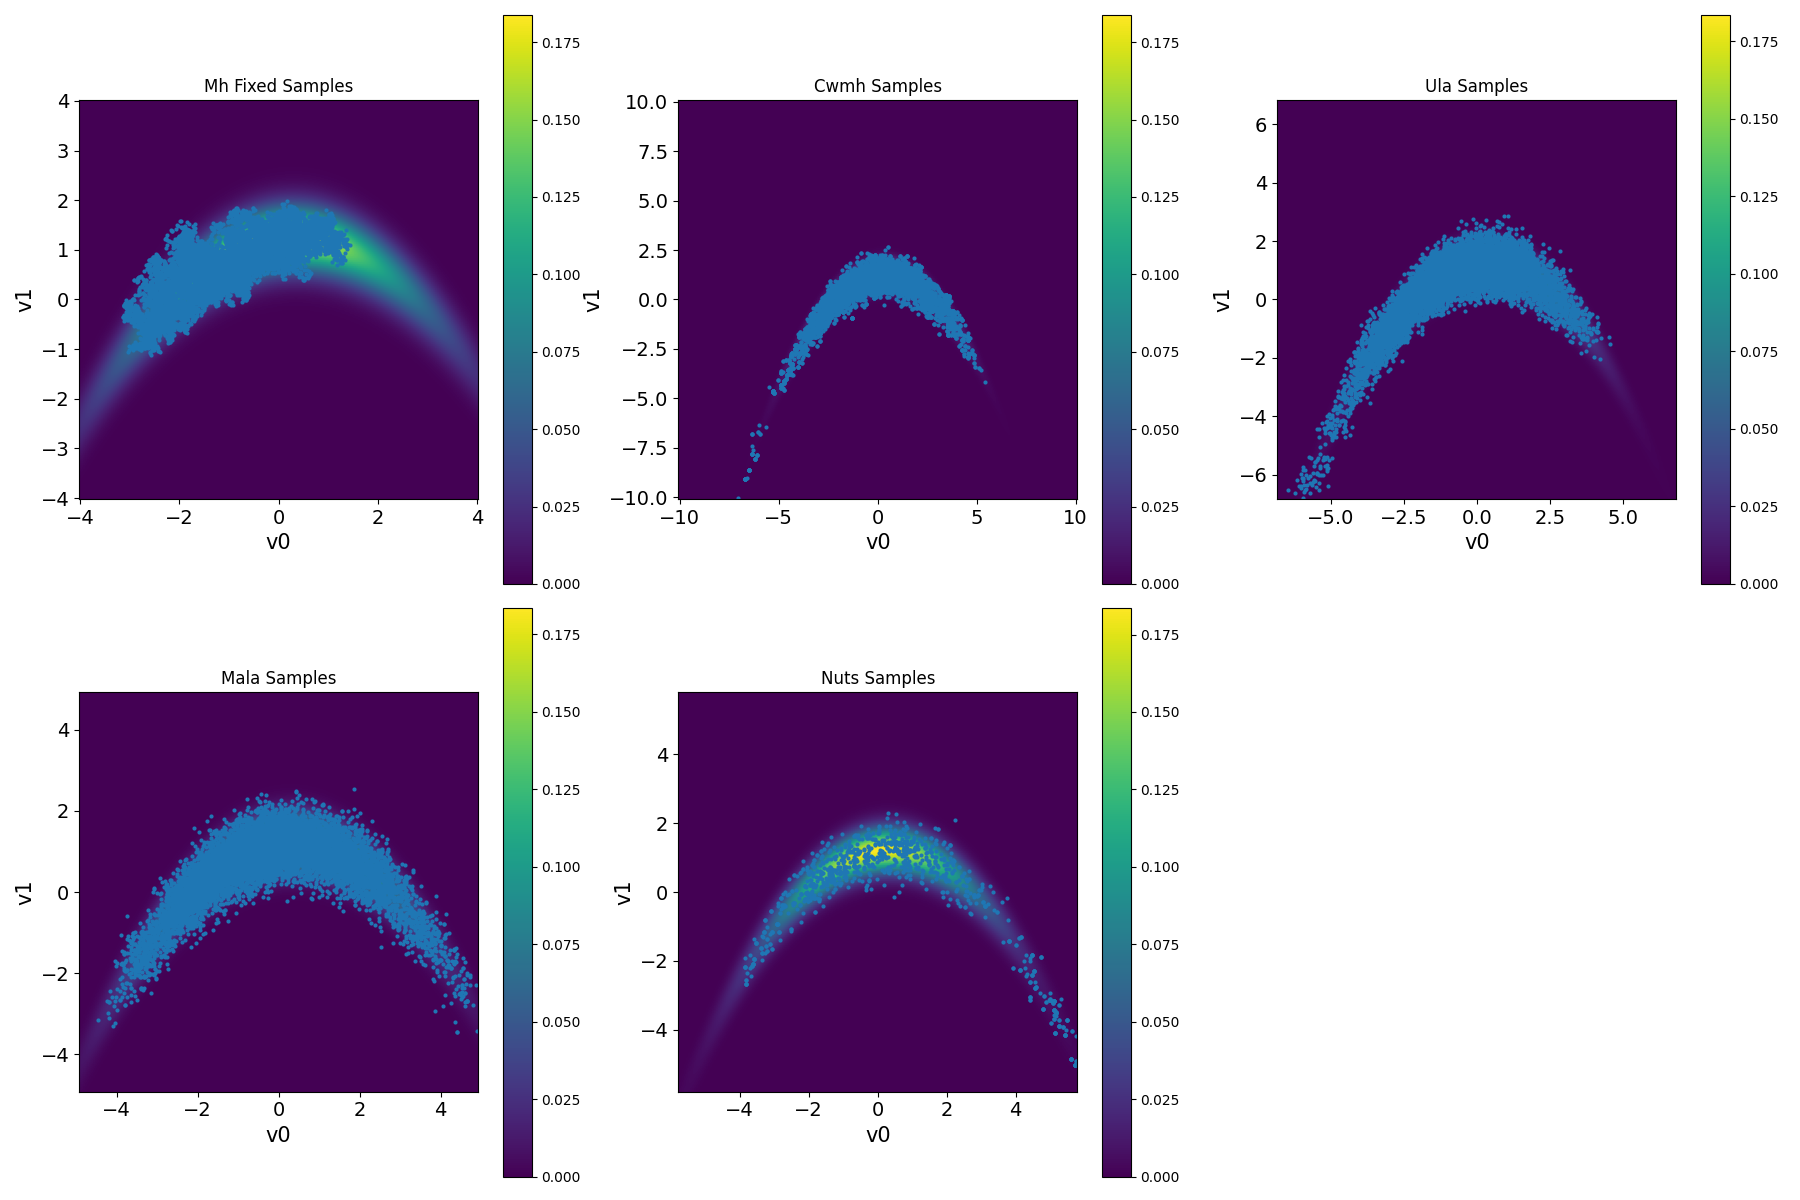

In [ ]:
TA.show_plot(fig)

_Observations_:
- From the graphs, the results from the table can be seen more clearly seen
- as expected the MH_fixed does not stray far away from the initial point 
- both MALA and NUTS provide quite an accurate sample representation 

## 2. Second example
In this example, we sample x0 from an initial dstribution, and we use the sam enumber of samples, burnins and the same scale for each method: 
- scale = 0.05
- Ns = 8500
- Nb = 1500

- Compute sampling methods

In [ ]:
true_mu = np.array([0, 0])
true_sigma = np.array([1,1])
y = cuqi.distribution.Gaussian(mean=true_mu, cov=true_sigma**2)

In [ ]:
df, (fig, axs) = TA.create_comparison(target_banana, 0.05, 8500, 1500, x0 = y, seed = 12,chains=2)

Sample 10000 / 10000

Average acceptance rate: 0.9504705882352941 

Sample 10000 / 10000

Average acceptance rate: 0.9501176470588235 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 500 / 10000

- Print table

In [ ]:
TA.print_table(df)

+------------+---------+----------+-------+---------+---------+-------+----------+----------+--------+----------+
|   Method   | Samples | Burn-ins | Scale | ESS(v0) | ESS(v1) |   AR  | Rhat(v0) | Rhat(v1) | LogPDF | Gradient |
+------------+---------+----------+-------+---------+---------+-------+----------+----------+--------+----------+
|  MH_fixed  |   8500  |   1500   |  0.05 |   1.44  |   1.84  |  0.95 |  1.648   |  1.442   | 10000  |    0     |
| MH_adapted |   8500  |   1500   |  0.05 |  52.906 | 128.642 | 0.636 |  1.004   |   1.0    | 10000  |    0     |
|    ULA     |   8500  |   1500   |  0.05 |  26.974 |  54.189 |  1.0  |  1.011   |  1.005   | 10000  |  10000   |
|    MALA    |   8500  |   1500   |  0.05 |  29.533 |  49.19  | 0.977 |  1.012   |   1.02   | 10000  |  10000   |
|    NUTS    |   8500  |   1500   |  0.05 | 145.116 | 291.716 | 0.705 |  1.009   |  1.001   | 40868  |  40868   |
+------------+---------+----------+-------+---------+---------+-------+----------+------

Observations:
- the  MH_fixed performs quite poorly, as ESS is very low, RHat strays from 1 and the AR is too high
- however, unlike in the donut distribution, the MH_adapted, performs better than expected, with Rhat close to 1.0 (converges well) and ESS, especially ESS(v1), is quite high 
- ULA has acceptence rate AR=1.0, as expected, and it performs well, with ESS parameters not too high but higher than MH, also R_hat is close to 1, meaing that it converges well enough
- MALA performs decently, but NUTS outperforms all the methods, but the computational costs are at least 4 times higher

- Create distribution images  

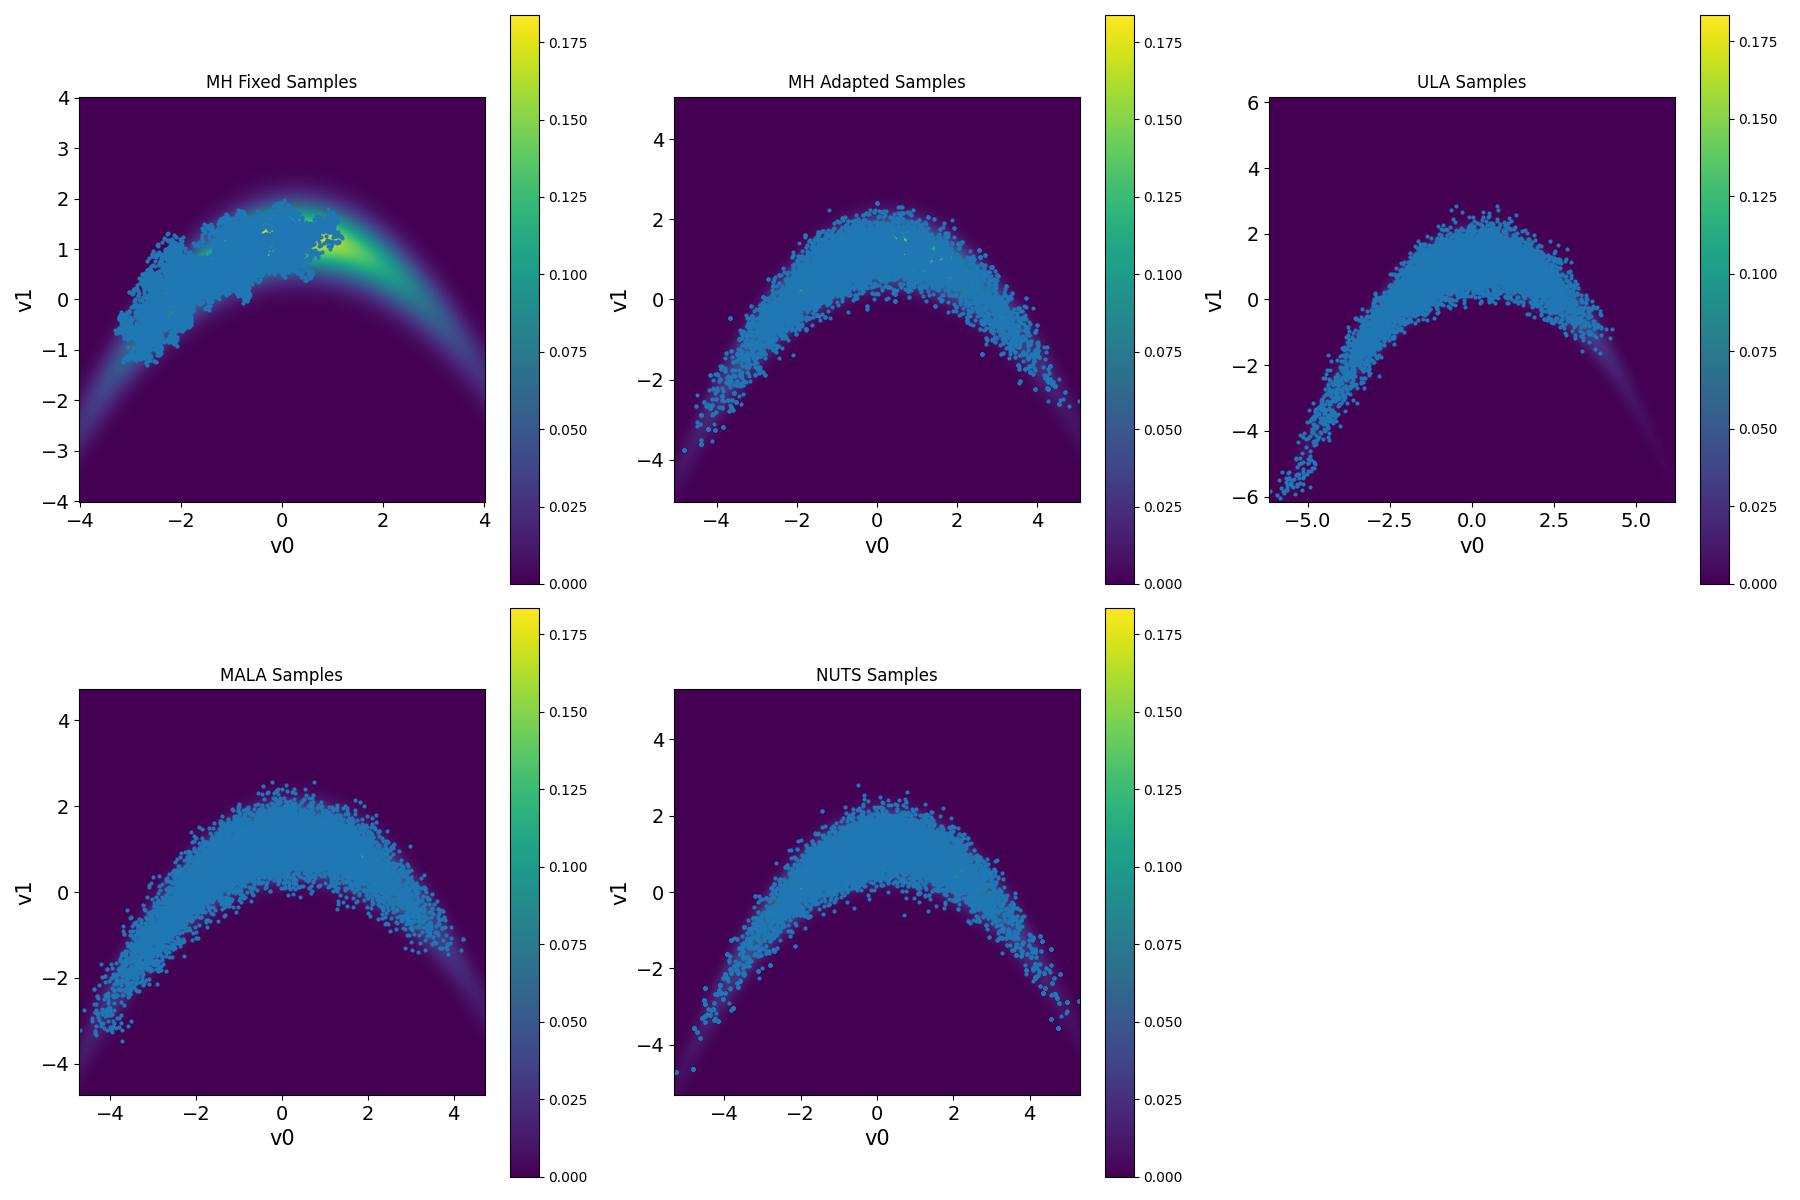

In [ ]:
TA.show_plot(fig)

_Observations_
- as expected the MH_fixed stays quite close to the initial point  
- compared to the previous graphss,it can be seen that setting a relatively high number of burn ins will lead to better results 